In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib.learn.python.learn.datasets.mnist import DataSet
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import dtypes
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
from copy import deepcopy
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
import logic


In [2]:
def sigma(x):
    return tf.div(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def split_mnist(mnist, cond):
    sets = ["train", "validation", "test"]
    sets_list = []
    for set_name in sets:
        this_set = getattr(mnist, set_name)
        maxlabels = np.argmax(this_set.labels, 1)
        sets_list.append(DataSet(this_set.images[cond(maxlabels),:], this_set.labels[cond(maxlabels)], 
                                 dtype=dtypes.uint8, reshape=False))
    return base.Datasets(train=sets_list[0], validation=sets_list[1], test=sets_list[2])    

In [5]:
dataset04 = split_mnist(mnist, lambda x: x < 5)
dataset59 = split_mnist(mnist, lambda x: (4 < x) & (x < 10))
mnist_list = [dataset04, dataset59]

In [6]:
a_0 = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

middle = 800

w_1 = tf.Variable(tf.truncated_normal([785, middle], stddev=0.1))
w_2 = tf.Variable(tf.truncated_normal([middle+1, 10], stddev=0.1))

w_old_1 = tf.Variable(tf.zeros([785, middle]))
w_old_2 = tf.Variable(tf.zeros([middle+1, 10]))

F_0 = tf.Variable(tf.eye(785))
F_1 = tf.Variable(tf.eye(middle+1))


ab_0 = tf.concat([a_0, tf.tile(tf.ones([1,1]), [tf.shape(a_0)[0], 1])], 1)
z_1 = tf.matmul(ab_0, w_1)
a_1 = sigma(z_1)
ab_1 = tf.concat([a_1, tf.tile(tf.ones([1,1]), [tf.shape(a_1)[0], 1])], 1)
z_2 = tf.matmul(ab_1, w_2)
a_2 = sigma(z_2)


diff = tf.subtract(a_2, y)


reg2 = tf.Variable(0.005)
reg1 = tf.Variable(0.005)

d_z_2 = tf.multiply(diff, sigmaprime(z_2))
dw_2 = tf.nn.l2_normalize(tf.matmul(tf.transpose(tf.matmul(ab_1,F_1)), d_z_2),0)

inc_w_2 = tf.subtract(w_2, w_old_2)
reg_w_2 = tf.multiply(reg2, inc_w_2)
d_w_2 = tf.add(dw_2, reg_w_2)


d_ab_1 = tf.matmul(d_z_2, tf.transpose(w_2))
d_a_1 = d_ab_1[:, :-1]
d_z_1 = tf.multiply(d_a_1, sigmaprime(z_1))
dw_1 = tf.nn.l2_normalize(tf.matmul(tf.transpose(tf.matmul(ab_0,F_0)), d_z_1),0)


inc_w_1 = tf.subtract(w_1, w_old_1)
reg_w_1 = tf.multiply(reg1, inc_w_1)
d_w_1 = tf.add(dw_1, reg_w_1)

In [7]:
eta = tf.constant(0.1)
step = [
    tf.assign(w_1,
            tf.subtract(w_1, tf.multiply(eta, d_w_1)))

  , tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta, d_w_2)))
]

acct_mat = tf.equal(tf.argmax(a_2, 1), tf.argmax(y, 1))
acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

In [8]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

A_0 = np.zeros([785, 785])
A_1 = np.zeros([middle+1, middle+1])

Training Disjoint MNIST 1
660.0
990.0
990.0
988.0
991.0
Accuracy on Current Dataset 0.9943568787701887
Test on Previous Datasets:
0.9943568787701887
C0


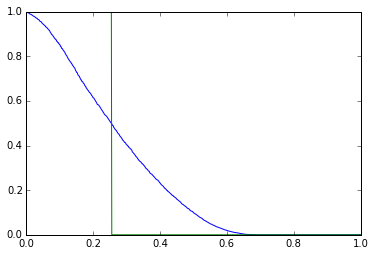

C1


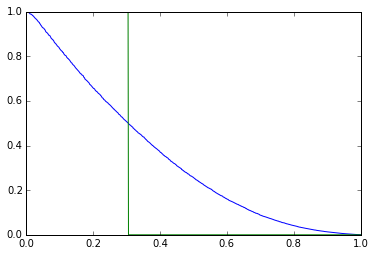

A


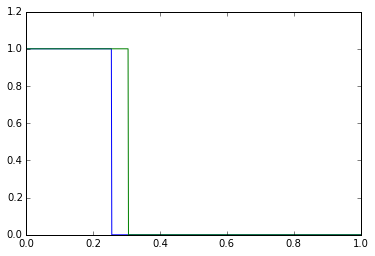

F


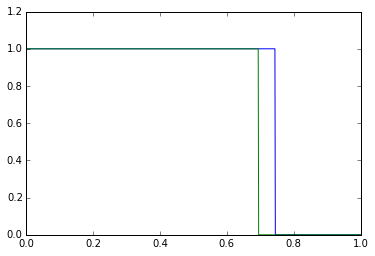

Training Disjoint MNIST 2
0.0
946.0
950.0
955.0
957.0
Accuracy on Current Dataset 0.9609133923061098
Test on Previous Datasets:
0.9365635337614322
0.9609133923061098
C0


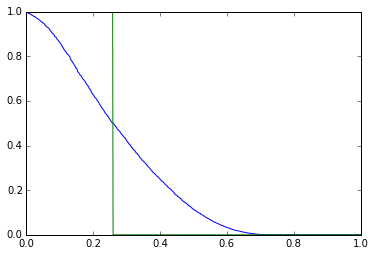

C1


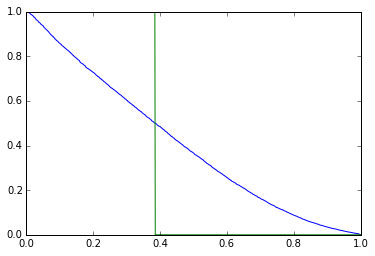

A


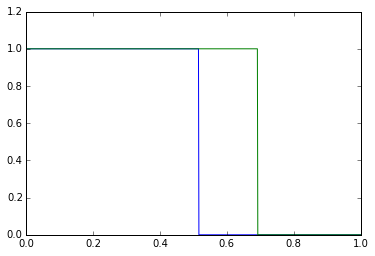

F


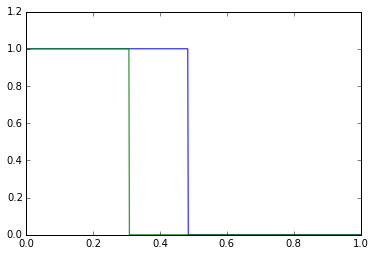

Final Total Accuracy: 0.9484


In [9]:
task_num = 2
for j in xrange(task_num):
    print "Training Disjoint MNIST %d" % (j+1)

    for i in xrange(10000):
        batch_xs, batch_ys = mnist_list[j].train.next_batch(300)

        sess.run(step, feed_dict = {a_0: batch_xs, y: batch_ys})

        if i % 1000 == 0:
            res = sess.run(acct_res, feed_dict =
                           {a_0:mnist_list[j].validation.images[:1000],
                            y : mnist_list[j].validation.labels[:1000]})
            print res
            if res > 990:
                break
            elif (res > 955 and j==1):
                break

    updateW_old = [tf.assign(w_old_1, w_1), tf.assign(w_old_2, w_2)]
    sess.run(updateW_old)


    res = sess.run(acct_res, feed_dict =
                           {a_0: mnist_list[j].test.images[:],
                            y : mnist_list[j].test.labels[:]})
    print "Accuracy on Current Dataset", res/mnist_list[j].test.labels.shape[0]


    print "Test on Previous Datasets:" 
    for i in xrange(j+1):
        res = sess.run(acct_res, feed_dict =
                               {a_0: mnist_list[i].test.images[:],
                                y : mnist_list[i].test.labels[:]})
        print res/mnist_list[i].test.labels.shape[0]

    a0_collection, _ = mnist_list[j].train.next_batch(1000)
    ab0_collection = sess.run(ab_0, feed_dict = {a_0: a0_collection})

    alpha = 9
    R_a0 = (ab0_collection.T).dot(ab0_collection) / ab0_collection.shape[0]
    U_a0, S_a0, _ = np.linalg.svd(R_a0)
    S_C0 = (np.diag(S_a0).dot(np.linalg.inv(np.diag(S_a0) + alpha ** (-2) * np.eye(ab0_collection.shape[1]))))
    Svec_C0 = np.diag(S_C0)


    S0 = (Svec_C0 >= 0.5).astype(int)
    C0 = U_a0.dot(np.diag(S0)).dot(U_a0.T)
    x = np.linspace(0,1,785)
    plt.plot(x,Svec_C0)
    plt.plot(x,S0)
    print "C0"
    plt.show()


    ab1_collection = sess.run(ab_1, feed_dict = {a_0: a0_collection})

    alpha1 = 9
    R_a1 = (ab1_collection.T).dot(ab1_collection) / ab1_collection.shape[0]
    U_a1, S_a1, _ = np.linalg.svd(R_a1)
    S_C1 = (np.diag(S_a1).dot(np.linalg.inv(np.diag(S_a1) + alpha1 ** (-2) * np.eye(ab1_collection.shape[1]))))
    Svec_C1 = np.diag(S_C1)


    S1 = (Svec_C1 >= 0.5).astype(int)
    C1 = U_a1.dot(np.diag(S1)).dot(U_a1.T)
    x1 = np.linspace(0,1,middle+1)
    plt.plot(x1,Svec_C1)
    plt.plot(x1,S1)
    print "C1"
    plt.show()



    A_0 = logic.OR(C0, A_0)
    A_1 = logic.OR(C1, A_1)
    U_A0, S_A0, _ = np.linalg.svd(A_0)
    U_A1, S_A1, _ = np.linalg.svd(A_1)

    plt.plot(x, S_A0)
    plt.plot(x1,S_A1)
    print "A"
    plt.show()

    F0 = logic.NOT(A_0)
    F1 = logic.NOT(A_1)

    U_F0, S_F0, _ = np.linalg.svd(F0)
    U_F1, S_F1, _ = np.linalg.svd(F1)
    plt.plot(x, S_F0)
    plt.plot(x1,S_F1)
    print "F"
    plt.show()


    updateF = [tf.assign(F_0, tf.cast(F0, tf.float32)), tf.assign(F_1, tf.cast(F1, tf.float32))]
    sess.run(updateF)

res = sess.run(acct_res, feed_dict =
                   {a_0: mnist.test.images[:],
                    y : mnist.test.labels[:]})

print "Final Total Accuracy:", res/mnist.test.labels.shape[0]